# Классификация текстов с использованием Наивного Байесовского Классификатора

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, Trials 


## Задание 1 (1 балл)

Откройте данные. Узнайте, сколько в них спам- и не спам-писем. Визуализируйте полученные соотношение подходящим образом.

In [42]:
emails = pd.read_csv('./spam_or_not_spam.csv')
emails

,email,label
0,date wed NUMBER aug NUMBER NUMBER NUMBER NUMB...,0
1,martin a posted tassos papadopoulos the greek ...,0
2,man threatens explosion in moscow thursday aug...,0
3,klez the virus that won t die already the most...,0
4,in adding cream to spaghetti carbonara which ...,0
...,...,...
2995,abc s good morning america ranks it the NUMBE...,1
2996,hyperlink hyperlink hyperlink let mortgage le...,1
2997,thank you for shopping with us gifts for all ...,1
2998,the famous ebay marketing e course learn to s...,1


In [43]:
proportion = emails['label'].value_counts()
proportion

label
0    2500
1     500
Name: count, dtype: int64

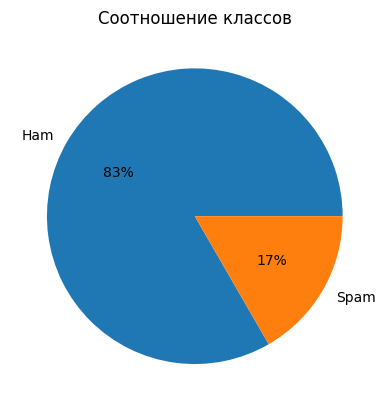

In [44]:
labels = ['Ham', 'Spam']
plt.pie(proportion, labels=labels, autopct='%.0f%%')
plt.title('Соотношение классов')
plt.show()


## Задание 2 (2 балла)

Вам необходимо предобработать ваши данные и перевести их в векторный вид. Подгрузим необходимый модуль:

In [45]:
from sklearn.feature_extraction.text import CountVectorizer

Замените в данных все пустые строки и строки, состоящие из пробелов, на пропуски (NaN). После этого удалите из данных все строки, в которых наблюдаются пропущенные значения.

In [46]:
emails_clean = emails.copy()
'''''
'\s+' - данный шаблон регулярного выражения:
1) заменит несколько идущих подряд пробельных символов между словами на один пробел;
2) строку, состоящую из одник пробелов заменит на один пробел
'''''
emails_clean['email'] = emails_clean['email'].str.replace('\s+', ' ')
# помечаем строки, состоящие из пробела как NaN
emails_clean[emails_clean['email'] == ' '] = np.nan
# помечаем пустые строки как NaN
emails_clean[emails_clean['email'] == ''] = np.nan
# удаляем строки с пропущенными значениями
emails_clean = emails_clean.dropna(subset=['email'])
emails_clean;

Переводим данные в векторный вид:

In [47]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(emails_clean["email"])
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

Определите, сколько теперь признаков в нашем наборе данных:

In [48]:
X.shape[1]

34116

## Задание 3 (2 балла)

Определите целевую переменную и признаки:

In [49]:
X = X.toarray()
y = emails_clean['label']

Разделите выборку на обучающую и тестовую, используя стратифицированное разбиение (параметр `stratify` установите в значение вектора ответов y) размер тестовой выборки (`test_size`) возьмите как 0.25, параметр `random_state` определите со значением 42:

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

Рассчитайте среднее значение целевой переменной по тестовой выборке:

In [51]:
round(y_test.mean(), 3)

0.165

## Задание 4 (3 балла)

Определите и обучите подходящий алгоритм с параметром alpha = 0.01

In [52]:
bayes = ComplementNB(alpha=0.01)
bayes.fit(X_train, y_train)
predicted = bayes.predict(X_test)
correct = (predicted == y_test).sum() / y_test.shape[0] * 100
print('Правильных предсказаний на тестовой выборке: {}%'.format(correct))

Правильных предсказаний на тестовой выборке: 98.8%


Оцените результат с точки зрения всех известных вам метрик (не менее трёх):

In [53]:
print('Precision = {} (on test sample)'.format(round(precision_score(y_test, predicted), 3)))
print('Accuracy = {} (on test sample)'.format(round(accuracy_score(y_test, predicted), 3)))
print('Recall = {} (on test sample)'.format(round(recall_score(y_test, predicted), 3)))

Precision = 1.0 (on test sample)
Accuracy = 0.988 (on test sample)
Recall = 0.927 (on test sample)


Нарисуйте ROC-кривую:

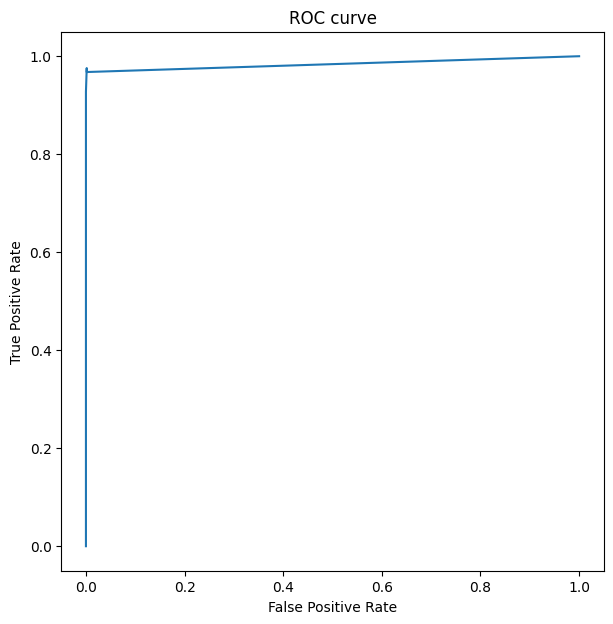

In [72]:
alphas = [0.01, 0.12, 0.23, 0.33, 0.5, 0.7, 0.8, 0.9]
false_positive_rates = [0.0]
true_positive_rates = [0.0]
for alpha in alphas:
    bayes = ComplementNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    predicted = bayes.predict(X_test)    
    false_positive_rate, true_positive_rate, _ = roc_curve(y_test, predicted)
    false_positive_rates.append(false_positive_rate[1])
    true_positive_rates.append(true_positive_rate[1])   
false_positive_rates.append(1.0)
true_positive_rates.append(1.0)
# создаем график
plt.figure(figsize=(7, 7))

# рисуем кривую
plt.plot(false_positive_rates, true_positive_rates, label='Сглаженные значения ROC-AUC')
#plt.fill_between(false_positive_rates, true_positive_rates, step="pre", alpha=0.4, label="Площадь под кривой (ROC-AUC)")
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Задание 5 (3 балла)

Переберите несколько значений alpha с помощью кросс-валидации. Оцените, зависит ли от этого параметра качество классификации.

100%|██████████| 20/20 [05:22<00:00, 16.13s/trial, best loss: -0.9702500284186936]
Наилучшие значения гиперпараметров {'alpha': 0.06}
Правильных предсказаний на тестовой выборке: 99.33333333333333%


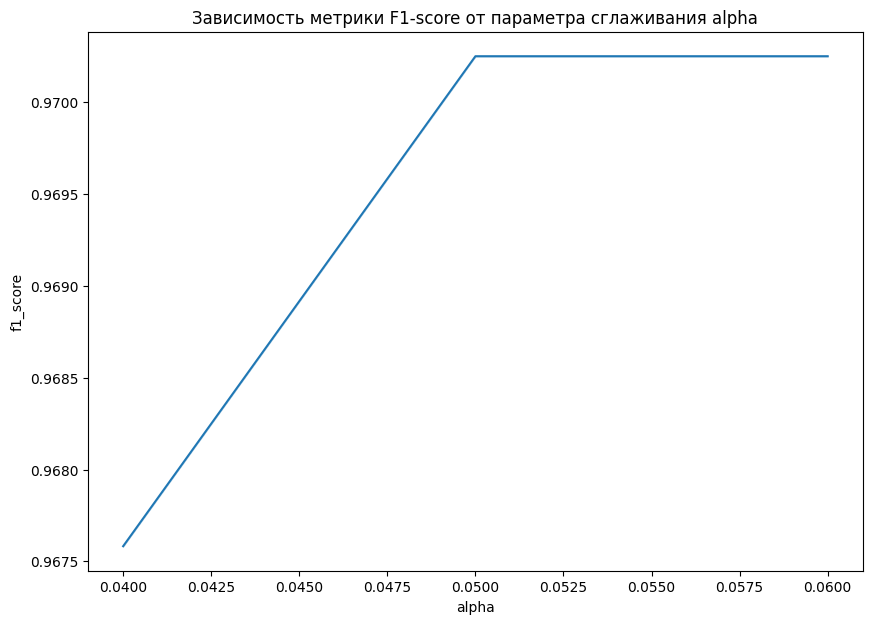

In [71]:
space = {'alpha': hp.quniform('alpha', 0.04, 0.06, 0.01)}
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=42):
    params = {'alpha': float(params['alpha'])}
    bayes = ComplementNB(**params)
    
    bayes.fit(X, y)
   
    # Применим cross_validation с тем же количеством фолдов
    score = cross_val_score(bayes, X, y, cv=cv, scoring='f1', n_jobs=-1).mean()
    return -score

trials = Trials()
best=fmin(
    hyperopt_rf,
    space=space,
    trials=trials,
    algo=tpe.suggest,
    max_evals=20,
    rstate=np.random.default_rng(42)
          )
print("Наилучшие значения гиперпараметров {}".format(best))
results = tpe_results=np.array([[-x['result']['loss'], x['misc']['vals']['alpha'][0]] for x in trials.trials])
tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['f1_score', 'alpha'])

results = tpe_results=np.array([[-x['result']['loss'], x['misc']['vals']['alpha'][0]] for x in trials.trials])
tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['f1_score', 'alpha'])
fig = plt.figure(figsize=(10, 7))
plot = sns.lineplot(data=tpe_results_df, x='alpha', y='f1_score')
plot.set_title('Зависимость метрики F1-score от параметра сглаживания alpha');

bayes = ComplementNB(alpha=best['alpha'])
bayes.fit(X_train, y_train)
predicted = bayes.predict(X_test)
correct = (predicted == y_test).sum() / y_test.shape[0] * 100
print('Правильных предсказаний на тестовой выборке: {}%'.format(correct))